In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns


In [3]:
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

# Create a duration column to calculate the lenght of each trip in minutes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds()/60)

# Select only rows where the duration is between 1-60 minuts
df = df[(df.duration>=1) & (df.duration<=60)].reset_index(drop=True)

# Select only rows where the taxis were dispatched
# df = df[df.trip_type == 2].reset_index(drop=True)
display(df.head())

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


### Print the preliminary stats and plot the distribution of the target variable

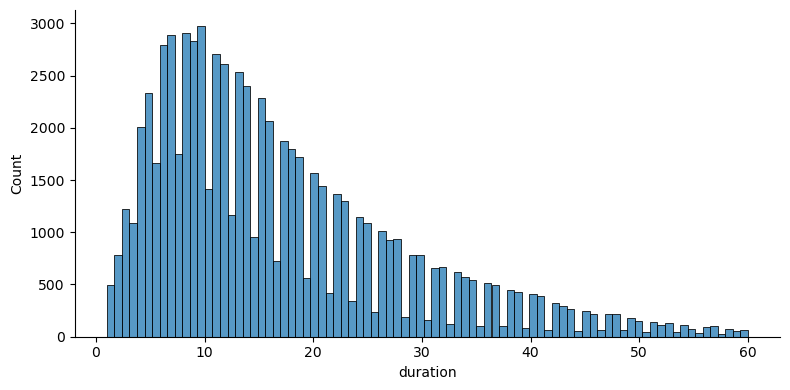

In [8]:
# df.dtypes
# display(df.duration.describe(percentiles=[0.95,0.98,0.99]))
sns.displot(df.duration, height=4,aspect=2).fig.set_dpi(100)
plt.show()

### Select the columns to train the model and perform one-hot encoding (OHE) on catergorical columns

In [9]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

# Convert the categorical columns to string so the OHE will work
df[categorical] = df[categorical].astype(str)

# Call the dictionary vectorizer from sklearn
dv = DictVectorizer()

# Convert the columns of interest to a dictionary
train_dicts = df[categorical + numerical].to_dict(orient='records')

### Create the training data

In [10]:
X_train = dv.fit_transform(train_dicts)
# To view all the categorical locations
# print(dv.feature_names_)

### Create the target dataset

In [11]:
target = 'duration'
y_train = df[target].to_numpy()

### Create the model

In [12]:
lr  = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

### Plot the difference between the trained and predicted data

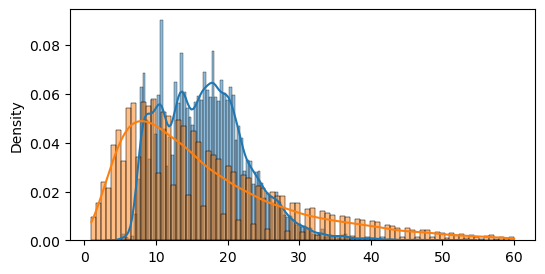

In [13]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(y_pred, label='prediction', ax=ax, kde=True, stat="density")
sns.histplot(y_train, label='actual', ax=ax, kde=True, stat="density")
plt.show()

In [14]:
# Setting squared to False is like rms
mse = mean_squared_error(y_train, y_pred, squared=False)
print(f'The baseline model is wrong by {mse:.2f} minutes')

The baseline model is wrong by 9.84 minutes


### Create a function to load and preprocess datasets by file paths

In [2]:
def load_data(path):
    df = pd.read_parquet(path)

    # Create a duration column to calculate the lenght of each trip in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)

    # Select only rows where the duration is between 1-60 minuts
    df = df[(df.duration>=1) & (df.duration<=60)].reset_index(drop=True)
    
    categorical = ['PULocationID','DOLocationID']
    # Convert the categorical columns to string so the OHE will work
    df[categorical] = df[categorical].astype(str)
    
    # Merge the pickup and drop off locations
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df


### Load the training dataframes

In [3]:
df_train = load_data('data/green_tripdata_2021-01.parquet') # January
df_val = load_data('data/green_tripdata_2021-02.parquet') # February

### Prepare the training dataset

In [4]:
categorical = ['PU_DO']
numerical = ['trip_distance']

# Call the dictionary vectorizer from sklearn
dv = DictVectorizer()

# Convert the columns of interest to a dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Create the training and test data
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Create the target variables
y_train = df_train['duration'].to_numpy()
y_val = df_val['duration'].to_numpy()

### Train the model and predict on the validation dataset

In [5]:
lr  = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

### Plot the difference between the training and predicition

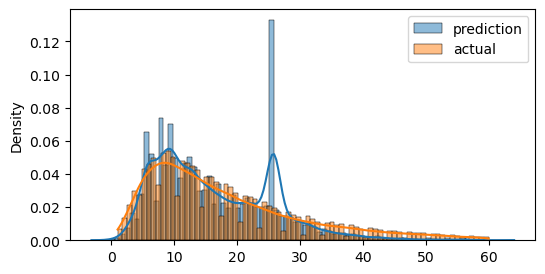

In [10]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(y_pred, label='prediction', ax=ax, kde=True, stat="density")
sns.histplot(y_val, label='actual', ax=ax, kde=True, stat="density")
plt.legend()
plt.show()

### Print the model errors

In [8]:
# Setting squared to False is like rms
mse = mean_squared_error(y_val, y_pred, squared=False)
print(f'The baseline model is wrong by {mse:.2f} minutes')

The baseline model is wrong by 7.76 minutes


### Save the trained model

In [9]:
# Save the model
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)